<a href="https://colab.research.google.com/github/GerardoMunoz/road/blob/main/cars_cnn_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
img_path='/content/images_road'

In [1]:
# prompt: Dounload and unzip url zip file

import requests
import zipfile
import io

url='https://github.com/GerardoMunoz/road/raw/refs/heads/main/dataset/cityscapes.zip'

try:
  response = requests.get(url, stream=True)
  response.raise_for_status()  # Raise an exception for bad status codes

  z = zipfile.ZipFile(io.BytesIO(response.content))
  z.extractall(img_path)
  print("Files extracted successfully.")

except requests.exceptions.RequestException as e:
  print(f"An error occurred during download: {e}")

except zipfile.BadZipFile:
  print(f"Invalid zip file.")

except Exception as e:
  print(f"An unexpected error occurred: {e}")


Files extracted successfully.


In [2]:
%cd '/content'
!pwd

/content
/content


In [3]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd GroundingDINO/
!pip install -q -e .

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 463 (delta 175), reused 135 (delta 135), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 14.28 MiB/s, done.
Resolving deltas: 100% (241/241), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 18.0 MB/s eta 0:00:00


In [4]:
%cd '/content'
!mkdir weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth -P weights
!pwd

/content
/content


In [5]:
!pip install supervision

* Entorno de ejecución -> Reiniciar sesión
* Entorno de ejecución -> Ejecutar celda y las de abajo

In [1]:
from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model("/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py",
     "weights/groundingdino_swint_ogc.pth")

final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [4]:
# import os
# import supervision as sv
# #img_path="/content/val2017/000000032901.jpg"
# text="road"#"T-Shirt Shirt Sweater Hoodie Jacket"
# BOX_THRESHOLD = 0.26
# TEXT_TRHESHOLD = 0.30
# image_source, image = load_image(img_path)
# boxes, logits,  phrases = predict(
#     model=model,
#     image=image,
#     caption=text,
#     box_threshold=BOX_THRESHOLD,
#     text_threshold=TEXT_TRHESHOLD,
#     device='cuda'
# )
# annotated_frame = annotate(
#     image_source=image_source,
#     boxes=boxes,
#     logits=logits,
#     phrases=phrases)

# sv.plot_image(annotated_frame,(16,16))

IsADirectoryError: [Errno 21] Is a directory: '/content/images_road'

In [ ]:
# boxes, logits,  phrases

[center_x(cx), center_y(cy),  right_x(rx), top_x(tx)]

* left,right,center,top,buttom

* cx=(rx+lx)/2
* lx=-rx+2cx

* cy=(by+ty)/2
* by=2cy-ty

[lx, ty, rx, by]

In [5]:
code={}

def yolo_format(boxes, logits,  phrases, alpha=0.5):
    yolo=[]
    for box, logit,  phrase in zip(boxes, logits,  phrases):
        if logit>alpha:
            if phrase not in code:
                code[phrase]=len(code)+1
            cx,cy,rx,ty=box
            lx=-rx+2*cx
            by=2*cy-ty
            yolo.append([code[phrase],lx,ty,rx-lx,by-ty])
    return yolo


# boxes_list =yolo_format(boxes, logits,  phrases)
# boxes_list

NameError: name 'boxes' is not defined

In [ ]:
# file_path = "label"+img_name[:-4]+".txt"

# # Write the list of tensors to a file
# with open(file_path, "w") as file:
#     for item in boxes_list:
#         # Extract the first element (integer) and the tensors
#         class_id = item[0]
#         tensor_values = [t.item() for t in item[1:]]  # Convert tensors to floats
#         # Combine the integer and tensor values into one line
#         file.write(f"{class_id} " + " ".join(map(lambda x:f"{x:.4f}", tensor_values)) + "\n")

# print(f"File saved at {file_path}")

In [6]:
def save_labels(img_path,label_path,show=False):
    #file_path = "label"+img_name[:-4]+".txt"

    image_source, image = load_image(img_path)
    boxes, logits,  phrases = predict(
        model=model,
        image=image,
        caption=text,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_TRHESHOLD,
        #device='cuda'
    )

    if show:
        annotated_frame = annotate(
            image_source=image_source,
            boxes=boxes,
            logits=logits,
            phrases=phrases)

        sv.plot_image(annotated_frame,(16,16))

    boxes_list =yolo_format(boxes, logits,  phrases)

    # Write the list of tensors to a file
    with open(label_path, "w") as file:
        for item in boxes_list:
            # Extract the first element (integer) and the tensors
            class_id = item[0]
            tensor_values = [t.item() for t in item[1:]]  # Convert tensors to floats
            # Combine the integer and tensor values into one line
            file.write(f"{class_id} " + " ".join(map(lambda x:f"{x:.4f}", tensor_values)) + "\n")
    print('.',end="")
    #print(f"File saved at {file_path}")


/content/images_road/5.jpg /content/yolo_labels/5.txt


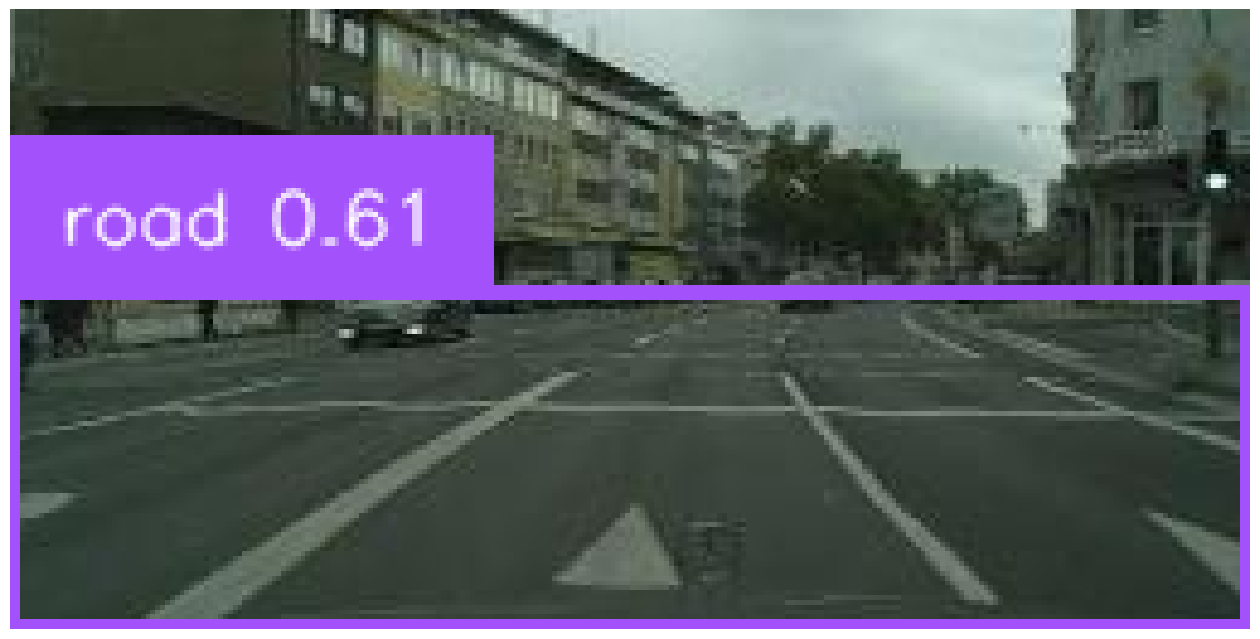

FileNotFoundError: [Errno 2] No such file or directory: '/content/yolo_labels/5.txt'

In [7]:
in_path='/content/images_road/'
out_path='/content/yolo_labels/'
img_name='5'
img_path=in_path+img_name+'.jpg'
lbl_path=out_path+img_name+'.txt'
print(img_path,lbl_path)


# save_labels(img_path,lbl_path,show=True)

In [8]:
# prompt: salve_labels for all files in in_path

import os

def salve_labels_for_all_files(in_path, out_path):
    for filename in os.listdir(in_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Adjust extensions as needed
            img_name = filename[:-4] # remove extension
            img_path = os.path.join(in_path, filename)
            lbl_path = os.path.join(out_path, img_name + '.txt')
            print(img_path, lbl_path)
            save_labels(img_path, lbl_path)

# Example usage
in_path = '/content/images_road/'
out_path = '/content/yolo_labels/'

# Create the output directory if it doesn't exist
os.makedirs(out_path, exist_ok=True)

salve_labels_for_all_files(in_path, out_path)

/content/images_road/1926.jpg /content/yolo_labels/1926.txt
./content/images_road/2157.jpg /content/yolo_labels/2157.txt
./content/images_road/1329.jpg /content/yolo_labels/1329.txt
./content/images_road/246.jpg /content/yolo_labels/246.txt
./content/images_road/2347.jpg /content/yolo_labels/2347.txt
./content/images_road/465.jpg /content/yolo_labels/465.txt
./content/images_road/806.jpg /content/yolo_labels/806.txt
./content/images_road/1615.jpg /content/yolo_labels/1615.txt
./content/images_road/735.jpg /content/yolo_labels/735.txt
./content/images_road/518.jpg /content/yolo_labels/518.txt
./content/images_road/2537.jpg /content/yolo_labels/2537.txt
./content/images_road/796.jpg /content/yolo_labels/796.txt
./content/images_road/403.jpg /content/yolo_labels/403.txt
./content/images_road/2721.jpg /content/yolo_labels/2721.txt
./content/images_road/2867.jpg /content/yolo_labels/2867.txt
./content/images_road/2822.jpg /content/yolo_labels/2822.txt
./content/images_road/846.jpg /content/

In [10]:
# prompt: zip all files of out_path

import os
import zipfile

def zip_files(directory_path, zip_filename):
  """Zips all files in the specified directory."""
  try:
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
      for root, _, files in os.walk(directory_path):
        for file in files:
          file_path = os.path.join(root, file)
          zipf.write(file_path, arcname=os.path.relpath(file_path, directory_path))
    print(f"Successfully zipped files to {zip_filename}")
  except Exception as e:
    print(f"An error occurred while zipping files: {e}")

# Example usage:
out_path = '/content/yolo_labels'
zip_filename = '/content/yolo_labels.zip' # Specify the desired zip file name
zip_files(out_path, zip_filename)

Successfully zipped files to /content/yolo_labels.zip


In [ ]:
stop

Ahora generar eel formato y entrenar Yolo o algo asi

In [ ]:
type(image_source), type(image)

In [ ]:
image_source.shape, image.shape,

In [ ]:
# Function to convert bounding boxes to YOLO format
def convert_to_yolo_format(boxes, image_width, image_height, class_id=0):
    yolo_boxes = []
    for box in boxes:
        # Extract coordinates
        x_min, y_min, x_max, y_max = box
        # Calculate YOLO format values
        x_center = ((x_min + x_max) / 2) / image_width
        y_center = ((y_min + y_max) / 2) / image_height
        width = (x_max - x_min) / image_width
        height = (y_max - y_min) / image_height
        # Append to list as a string
        yolo_boxes.append(f"{class_id} {x_center} {y_center} {width} {height}")
    return yolo_boxes

# Image dimensions
image_height, image_width, _ = image.shape

# Convert boxes to YOLO format
yolo_annotations = convert_to_yolo_format(boxes, image_width, image_height)

# Save annotations to a file
output_dir = "/content/yolo_labels/"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, os.path.basename(img_path).replace('.jpg', '.txt'))

with open(output_path, "w") as f:
    f.write("\n".join(yolo_annotations))

print(f"YOLO annotations saved to: {output_path}")

In [ ]:

import supervision as sv